In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

In [4]:
df = pd.read_csv('../data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
X = df.drop(['Class','Time'], axis=1)
y = df['Class']

In [7]:
y.value_counts(normalize=True  * 100)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,   # 20% test, 80% train
    random_state=42, # ensures reproducibility
    stratify=y       # keeps the same fraud/non-fraud ratio in train and test
)

In [9]:
scaler = StandardScaler()

In [10]:
# Create copies of the datasets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only the Amount column
# Reshape for scalar operations
X_train_scaled['Amount'] = scaler.fit_transform(X_train_scaled[['Amount']])

# Use the same scaler (fit on train data) for test data
X_test_scaled['Amount'] = scaler.transform(X_test_scaled[['Amount']])

In [20]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,033 (15.75 KB)

 Trainable params: 4,033 (15.75 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='roc_auc')]
)

In [25]:
early_stop = EarlyStopping(monitor='val_roc_auc', patience=5, mode='max', restore_best_weights=True)

In [22]:
# Calculate class weights to handle imbalanced data
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Print weights to verify the balance
print("Class Weights:")
print(f"Non-Fraud (0): {class_weights[0]:.3f}")
print(f"Fraud (1): {class_weights[1]:.3f}")
print(f"Ratio (Fraud/Non-Fraud): {class_weights[1]/class_weights[0]:.1f}x")

Class Weights:
Non-Fraud (0): 0.501
Fraud (1): 289.143
Ratio (Fraud/Non-Fraud): 577.3x


In [26]:
# Train the model with class weights and early stopping
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2954 - roc_auc: 0.9352 - val_loss: 0.1676 - val_roc_auc: 0.9898
Epoch 2/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2954 - roc_auc: 0.9352 - val_loss: 0.1676 - val_roc_auc: 0.9898
Epoch 2/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1744 - roc_auc: 0.9777 - val_loss: 0.1062 - val_roc_auc: 0.9926
Epoch 3/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1744 - roc_auc: 0.9777 - val_loss: 0.1062 - val_roc_auc: 0.9926
Epoch 3/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1634 - roc_auc: 0.9789 - val_loss: 0.1035 - val_roc_auc: 0.9893
Epoch 4/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1634 - roc_auc: 0.9789 - val_loss: 0.1035 - val_roc_auc: 0.9893
Epoch 4/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1446 - roc_auc: 0.9834 - val_loss: 0.0806 - val_roc_auc: 0.9904
Epoch 5/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1446 - roc_auc: 0.9834 - val_loss: 0.0806 - val_

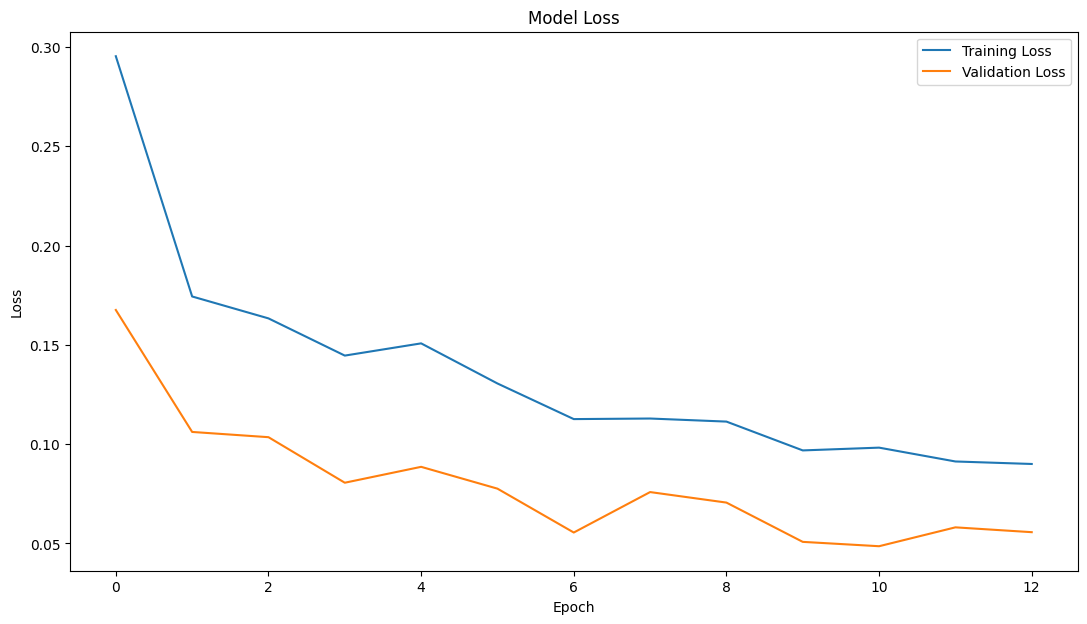

In [ ]:
# Plot training history
plt.figure(figsize=(13, 7))

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

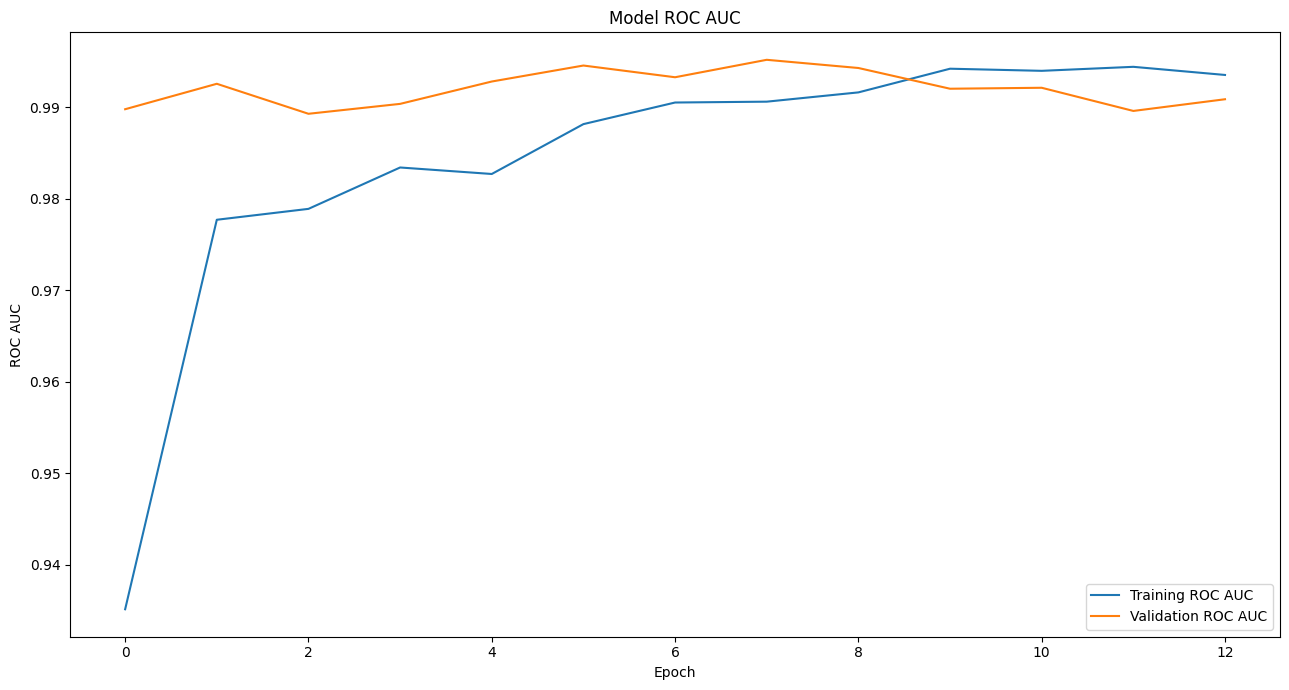

In [32]:
# Plot ROC AUC
plt.figure(figsize=(13, 7))
plt.plot(history.history['roc_auc'], label='Training ROC AUC')
plt.plot(history.history['val_roc_auc'], label='Validation ROC AUC')
plt.title('Model ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.legend()
plt.tight_layout()
plt.show()

# Threshold = 0.5

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.91      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.91      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.99     56962



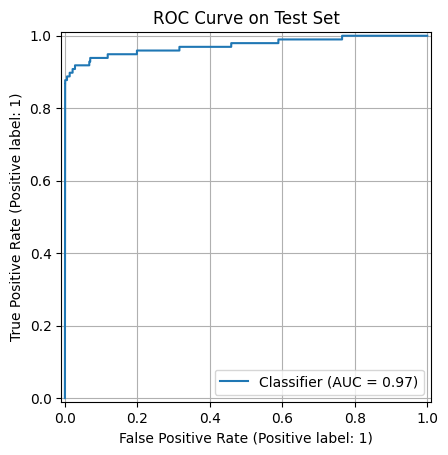

In [33]:
# Evaluate model on test set
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve on Test Set')
plt.grid(True)
plt.show()

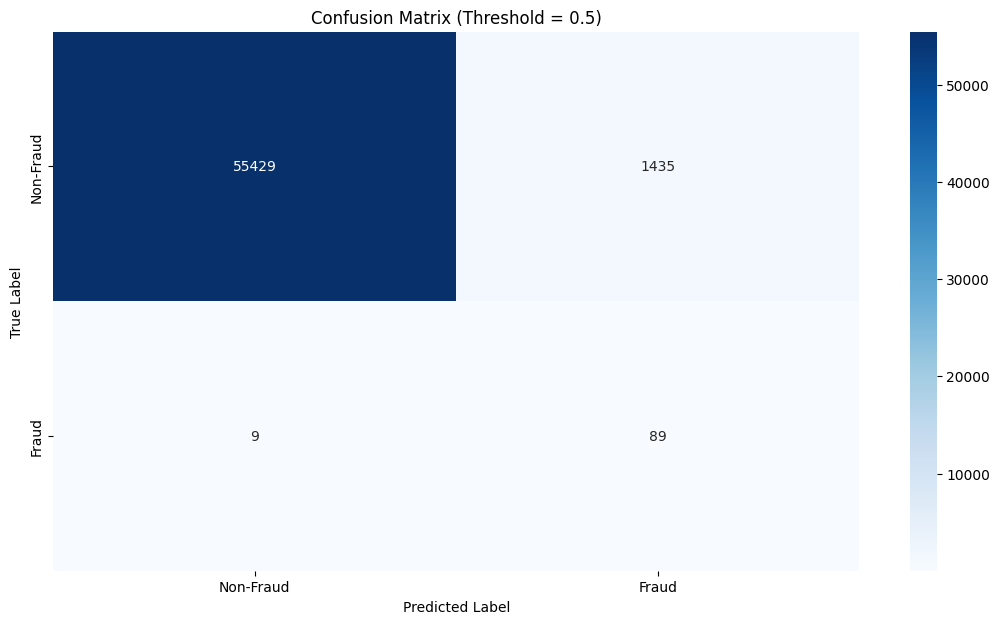


Confusion Matrix Raw Numbers:
True Negatives: 55429
False Positives: 1435
False Negatives: 9
True Positives: 89


In [34]:
# Create confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(13, 7))
sns.heatmap(cm,
            annot=True,           # Show numbers in cells
            fmt='g',              # Format numbers as integers
            cmap='Blues',         # Blue color scheme
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])

plt.title('Confusion Matrix (Threshold = 0.5)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print raw numbers
print("\nConfusion Matrix Raw Numbers:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

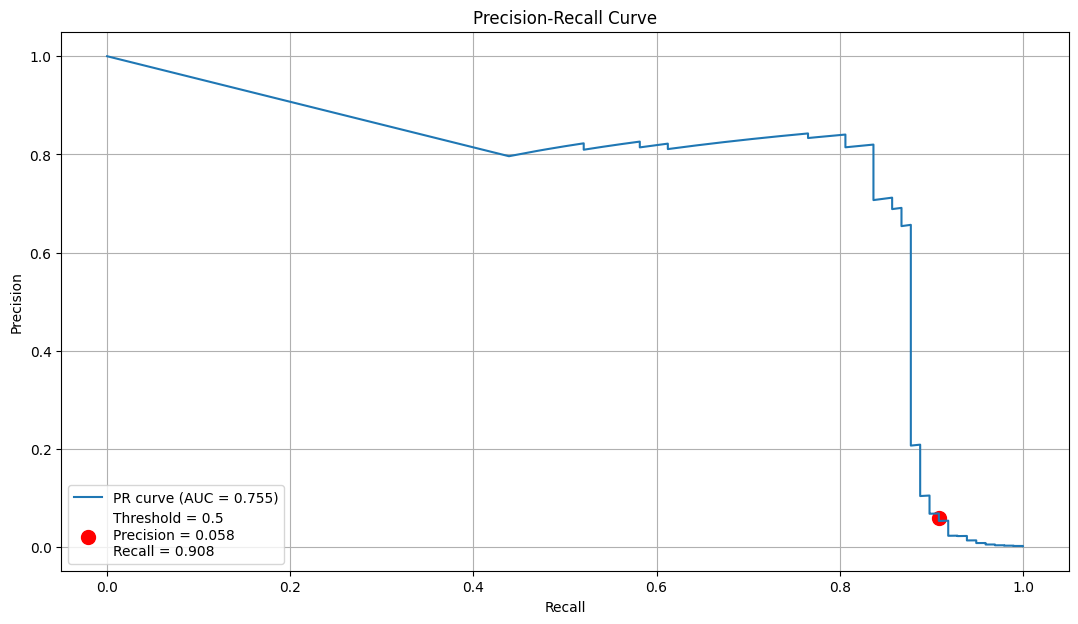

Precision-Recall AUC: 0.755

At threshold 0.5:
Precision: 0.058
Recall: 0.908


In [36]:
# Calculate and plot Precision-Recall curve
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Find precision and recall at threshold 0.5
threshold_idx = np.argmin(np.abs(thresholds - 0.5))
precision_at_05 = precision[threshold_idx]
recall_at_05 = recall[threshold_idx]

# Plot Precision-Recall curve
plt.figure(figsize=(13, 7))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.scatter(recall_at_05, precision_at_05, color='red', s=100,
           label=f'Threshold = 0.5\nPrecision = {precision_at_05:.3f}\nRecall = {recall_at_05:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

print(f"Precision-Recall AUC: {pr_auc:.3f}")
print(f"\nAt threshold 0.5:")
print(f"Precision: {precision_at_05:.3f}")
print(f"Recall: {recall_at_05:.3f}")

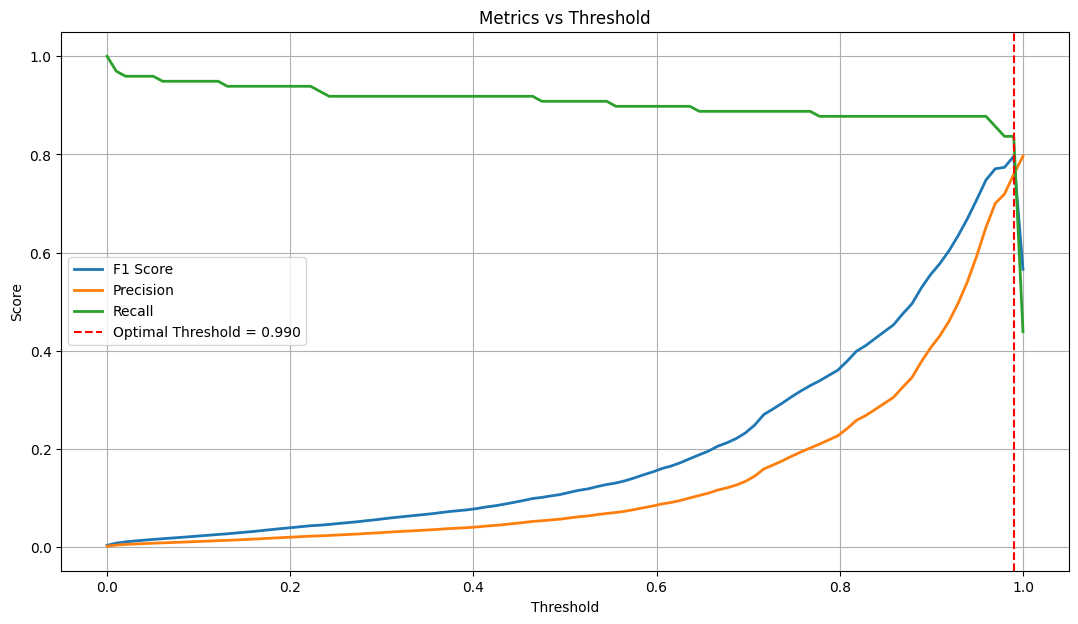

Optimal Threshold: 0.990
Best F1 Score: 0.796

Original F1 Score (threshold=0.5): 0.110


In [37]:
# Find threshold that maximizes F1 score
thresholds = np.linspace(0, 1, 100)
f1_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_threshold))
    precision_scores.append(precision_score(y_test, y_pred_threshold))
    recall_scores.append(recall_score(y_test, y_pred_threshold))

# Find optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

# Plot metrics vs threshold
plt.figure(figsize=(13, 7))
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
plt.plot(thresholds, precision_scores, label='Precision', linewidth=2)
plt.plot(thresholds, recall_scores, label='Recall', linewidth=2)
plt.axvline(x=optimal_threshold, color='r', linestyle='--',
            label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.show()

print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"Best F1 Score: {optimal_f1:.3f}")

# Compare with original threshold (0.5)
original_f1 = f1_score(y_test, y_pred)
print(f"\nOriginal F1 Score (threshold=0.5): {original_f1:.3f}")

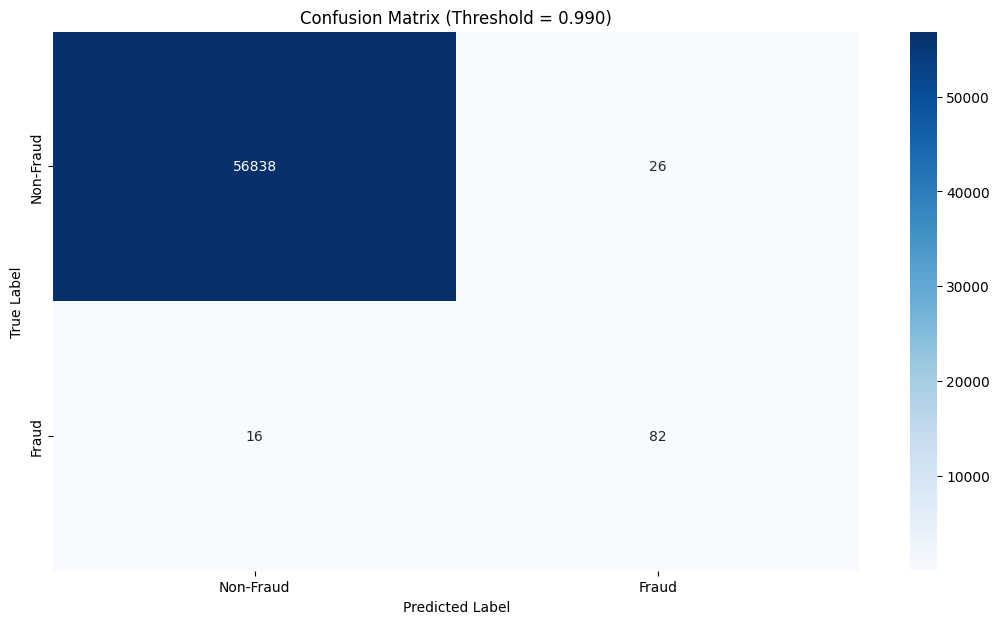


Metrics at Optimal Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.84      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [38]:
# Create confusion matrix for optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

# Plot confusion matrix
plt.figure(figsize=(13, 7))
sns.heatmap(cm_optimal,
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])

plt.title(f'Confusion Matrix (Threshold = {optimal_threshold:.3f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print metrics at optimal threshold
print("\nMetrics at Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

In [39]:
from joblib import dump, load

# Save the model
model_path = 'deep_learning_fraud_detector_22-9-2025.joblib'

# Save the model
dump(model, model_path)
print(f"Model saved to: {model_path}")

Model saved to: deep_learning_fraud_detector_22-9-2025.joblib
